# Определение стоимости автомобилей

## Цели и задачи исследования

**Цель исследования** — построить модель для предсказания стоимости подержанного автомобиля на основе имющихся данных о технических хараектристиках и комплектаци. 

Результаты исследования будут использоваться в приложении для быстрого определения рыночной стоимости машины, поэтому необходимо оценивать как точность предсказания, так и скорость обучения и работы модели.

**Задачи (этапы) исследования:**
1. Подготовить данные (заполнить или удалить пропуски, обработать аномалии, выделить значимые признаки);
2. Построить и оценить точность нескольких моделях, в том числе LightGBM. Оценка будет производиться при помощи метрики RMSE (RMSE должен быть не более 2500);
3. Оценить скорость работы моделей. Выбрать оптимальную с точки зрения точности и скорости предсказания, протестировать эту модель на тестовой выборке.

## Подготовка данных

In [1]:
#!pip install lightgbm -q

In [2]:
# Импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

plt.style.use('dark_background')
warnings.filterwarnings('ignore')

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('/content/autos.csv')

In [4]:
# Смотрим на первые пять строк
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21


In [5]:
# Приведем названия колонок к snake_case
df.columns = (
    df.columns.str.replace
    (r'([A-Z])', r' \1').str.lower()
    .str.replace(' ', '_').str[1:]
)


In [6]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [7]:
# Делаем функцию для обзора данных
def data_overview(data):
    '''
    Функция для обзора данных,
    принимает на вход датафрейм,
    выводит на экран его основные характеристики
    и графики
    '''
    
    print('Общая информация о данных (info)', (80 - len('Общая информация о данных (info)')) * '-', '\n')
    data.info()
    print('')
    print('Статистические показатели (describe)', (80 - len('Статистические показатели (describe)')) * '-')
    display(data.describe().T)
    print('')
    print ('Пропущенные значения в данных', (80 - len('Пропущенные значения в данных')) * '-')
    print('')
    empty = sum(data.isna().sum())
    if empty > 0:
        print(f'Общее количество пропусков в данных: {empty}')
        print()
        (
            (data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', legend = False, figsize=(40,20),
                  fontsize = 22)
            .set_title('Количество пропусков по колонкам' + "\n", fontsize = 26)
        )
    else:
        print('Пропущенных значений нет')
    print('')
    print('Дубликаты в данных', (80 - len('Дубликаты в данных')) * '-')
    print('')
    if data.duplicated().sum() > 0:
        print (f'Количество дубликатов в данных: {data.duplicated().sum()}')
    else:
        print('Дубликатов нет')
    

Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309916 entries, 0 to 309915
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        309916 non-null  object 
 1   price               309916 non-null  int64  
 2   vehicle_type        277064 non-null  object 
 3   registration_year   309916 non-null  int64  
 4   gearbox             292579 non-null  object 
 5   power               309915 non-null  float64
 6   model               292606 non-null  object 
 7   kilometer           309915 non-null  float64
 8   registration_month  309915 non-null  float64
 9   fuel_type           281090 non-null  object 
 10  brand               309915 non-null  object 
 11  repaired            247671 non-null  object 
 12  date_created        309915 non-null  object 
 13  number_of_pictures  309915 non-null  float64
 14  

,count,mean,std,min,25%,50%,75%,max
price,309916.0,4422.146911,4520.614411,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,309916.0,2004.234344,90.953537,1000.0,1999.0,2003.0,2008.0,9999.0
power,309915.0,110.236529,194.348057,0.0,69.0,105.0,142.0,20000.0
kilometer,309915.0,128134.327154,37968.798655,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,309915.0,5.710388,3.726536,0.0,3.0,6.0,9.0,12.0
number_of_pictures,309915.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,309915.0,50488.592692,25783.613054,1067.0,30163.0,49377.0,71083.0,99998.0



Пропущенные значения в данных ---------------------------------------------------

Общее количество пропусков в данных: 158578


Дубликаты в данных --------------------------------------------------------------

Количество дубликатов в данных: 3


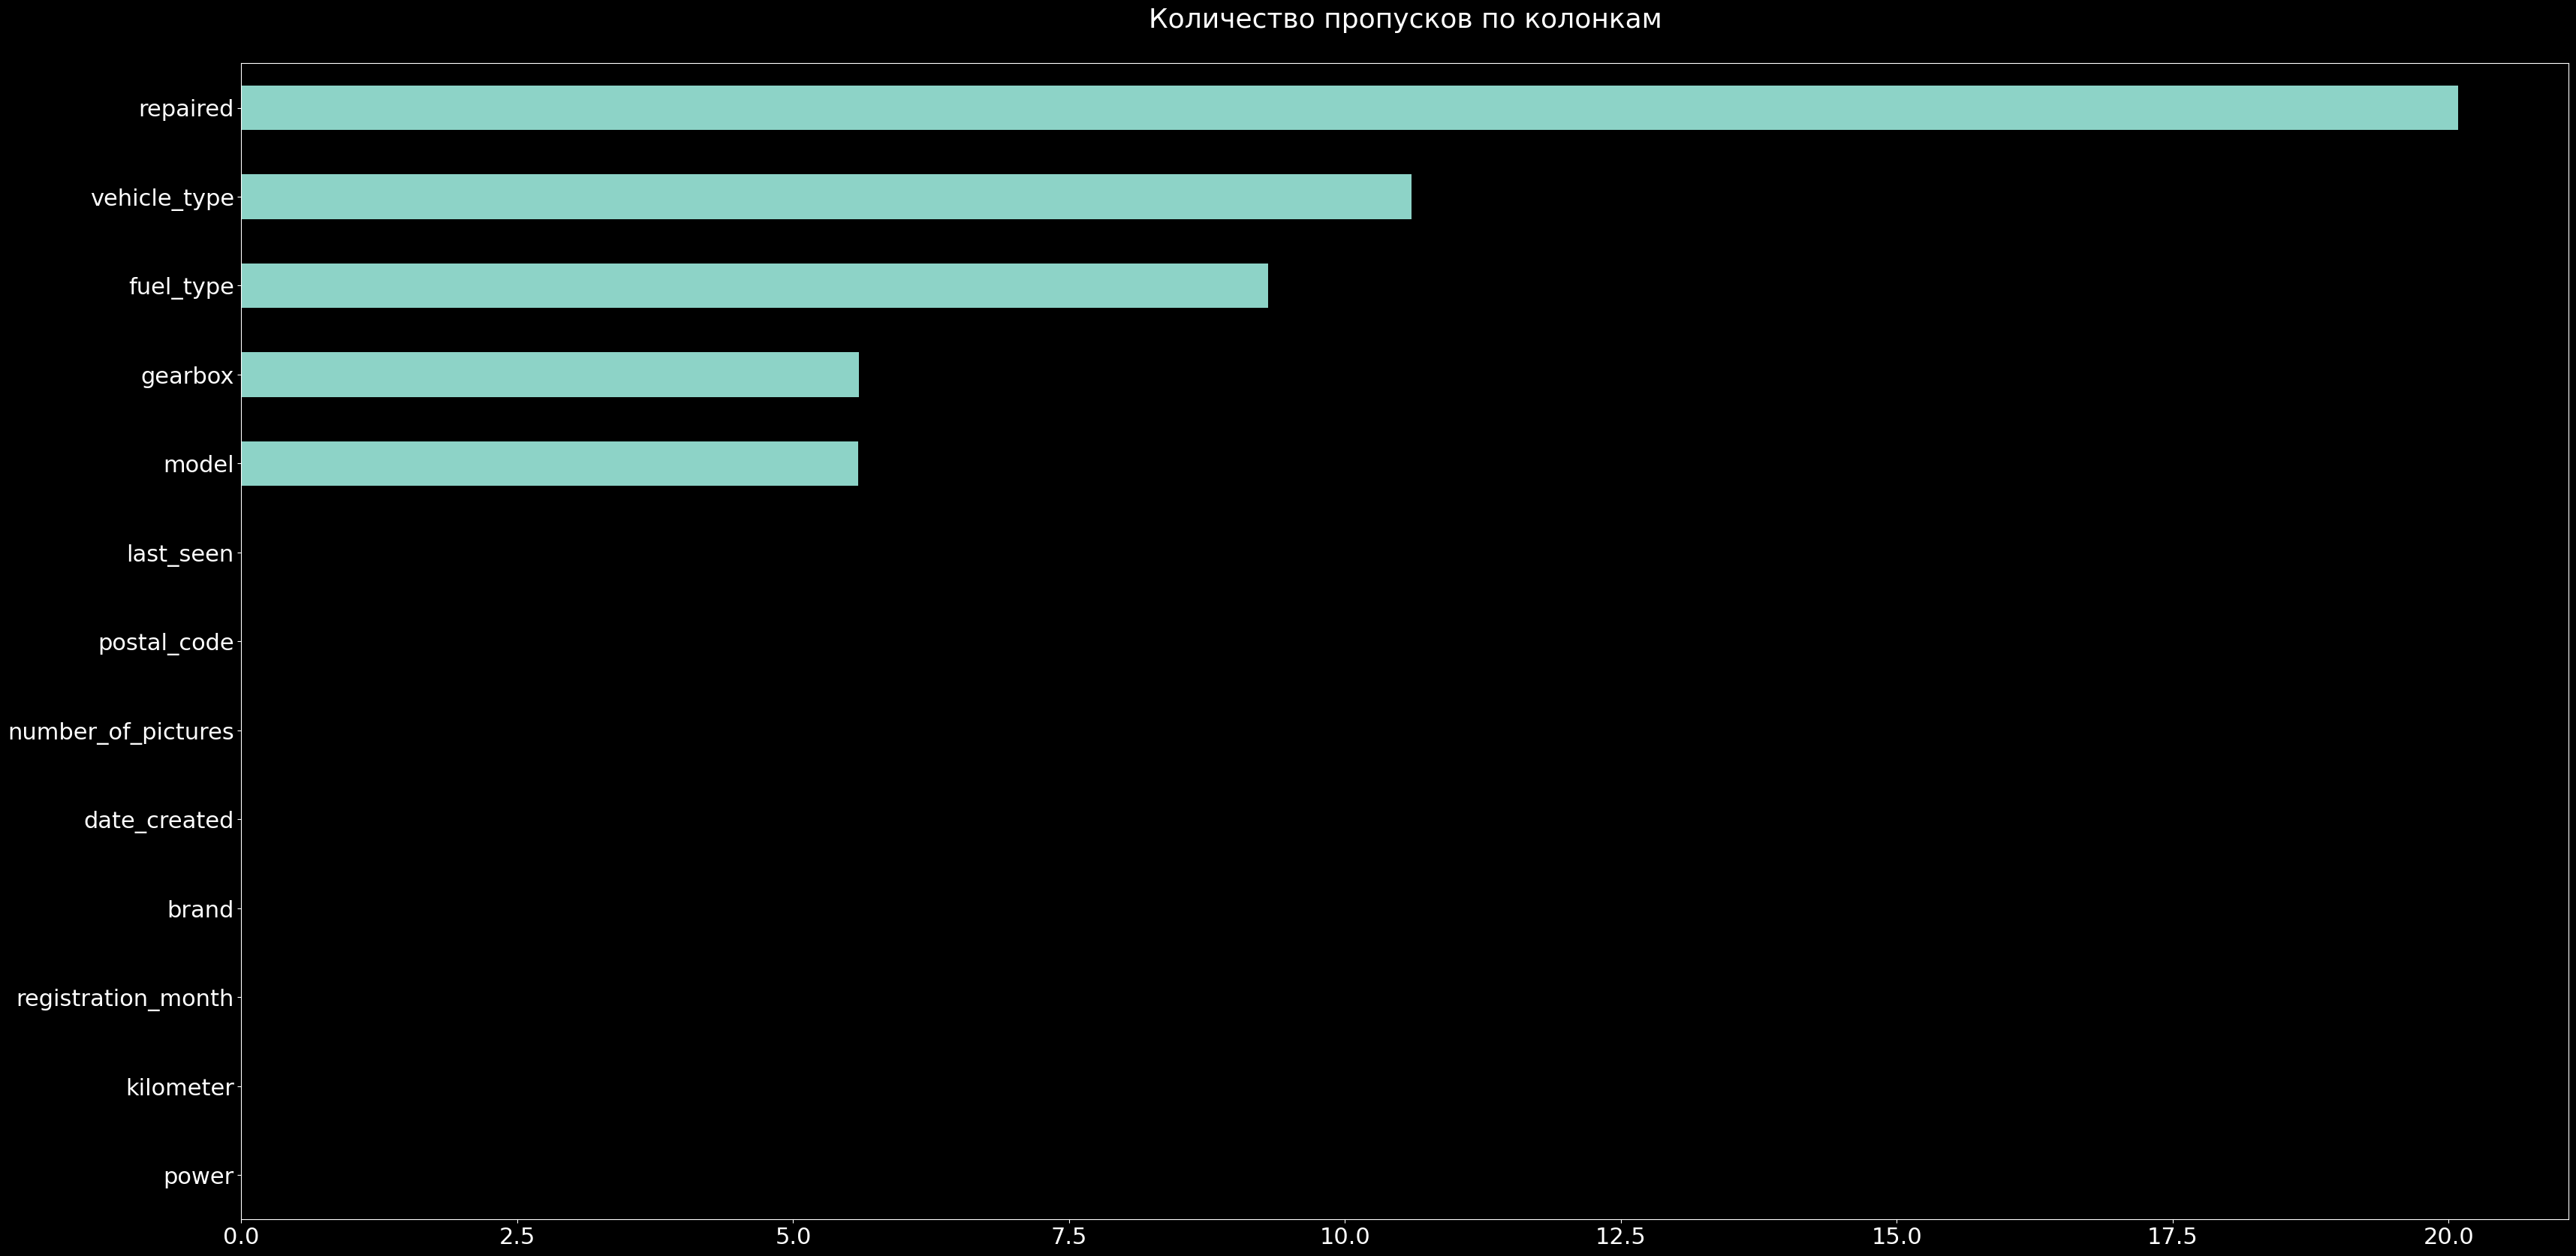

In [8]:
data_overview(df)

После обзора данных мы выяснили:
1. В датафрейме 354 369 записей;
2. В данных имеется небольшое число дубликатов (4) и значительное количество пропусков: больше всего пропущенных значений — в столбце `repaired` (была машина в ремонте или нет), также есть пропуски в столбцах `vehicle_type` (тип кузова), `fuel_type` (тип топлива), `gearbox` (тип коробки передач), `model` (модель).

Чтобы решить, как поступить с пропусками, и исследовать аномалии в данных, посмотрим на распределения и типы значений.

### Удаление незначимых признаков

In [9]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

У нас есть несколько временных признаков (`date_crawled`, `registration_year`, `registration_month`, `date_created`, `last_seen`).

In [10]:
df['date_crawled'].sort_values().unique()

array(['2016-03-05 14:06:23', '2016-03-05 14:06:24',
       '2016-03-05 14:06:25', ..., '2016-04-07 14:36:54',
       '2016-04-07 14:36:55', '2016-04-07 14:36:58'], dtype=object)

In [11]:
df['date_created'].sort_values().unique()

array(['2014-03-10 00:00:00', '2015-03-20 00:00:00',
       '2015-08-07 00:00:00', '2015-08-10 00:00:00',
       '2015-09-04 00:00:00', '2015-11-02 00:00:00',
       '2015-11-08 00:00:00', '2015-11-10 00:00:00',
       '2015-11-12 00:00:00', '2015-11-17 00:00:00',
       '2015-11-23 00:00:00', '2015-11-24 00:00:00',
       '2015-12-05 00:00:00', '2015-12-06 00:00:00',
       '2015-12-17 00:00:00', '2015-12-27 00:00:00',
       '2015-12-30 00:00:00', '2016-01-02 00:00:00',
       '2016-01-03 00:00:00', '2016-01-06 00:00:00',
       '2016-01-07 00:00:00', '2016-01-08 00:00:00',
       '2016-01-10 00:00:00', '2016-01-13 00:00:00',
       '2016-01-15 00:00:00', '2016-01-16 00:00:00',
       '2016-01-17 00:00:00', '2016-01-18 00:00:00',
       '2016-01-19 00:00:00', '2016-01-20 00:00:00',
       '2016-01-22 00:00:00', '2016-01-23 00:00:00',
       '2016-01-24 00:00:00', '2016-01-25 00:00:00',
       '2016-01-26 00:00:00', '2016-01-27 00:00:00',
       '2016-01-28 00:00:00', '2016-01-29 00:0

In [12]:
df['last_seen'].sort_values().unique()

array(['2016-03-05 14:15:08', '2016-03-05 14:15:16',
       '2016-03-05 14:15:39', ..., '2016-04-07 14:58:49',
       '2016-04-07 14:58:50', nan], dtype=object)

Анкеты создавались в течение 2015—2016 годов, а скачивались из базы и в последний раз просматривались в течение 2016 года. Эти признаки мы позже удалим, т. к. для предсказания модели они не значимы.

In [13]:
df['registration_month'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       nan])

В столбце с месяцем регистрации автомобиля присутствует 13 уникальных значений - от 0 до 12. Поскольку данный признак также не представляется значимым, мы его удалим. Из признаков со значениями времени (даты) мы оставим только год регистрации, поскольку, возможно, год регистрации связан с годом выпуска машины, а это важный признак для предсказания цены.

In [14]:
# Посмотрим, какие значения содержатся в столбце postal_code
df['postal_code'].head()

0    70435.0
1    66954.0
2    90480.0
3    91074.0
4    60437.0
Name: postal_code, dtype: float64

In [15]:
df['postal_code'].nunique()

8120

В этой колонке много уникальных значений, которые являются по сути категориальными, а не численными, поэтому данный признак также нужно удалить. Кроме того, для предсказания этот признак, скорее всего, не значим.

In [16]:
df['number_of_pictures'].unique()

array([ 0., nan])

В этом столбце только нулевые значения, так что его мы тоже удалим.

In [17]:
# Удаляем признаки, которые не являются значимыми для предсказания
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures',
              'postal_code', 'last_seen'], axis=1)

In [18]:
#Удалим дубликаты
df = df.drop_duplicates()

#### Вывод по разделу
На этом этапе исследования мы удалили признаки, которые, по всей вероятности, не будут влиять на качество предсказания. При этом мы посмотрели на диапазон дат, в которые производилась работа с анкетами, и установили, что этот период — 2015—2016 годы, т.е. машин, зарегистрированных позже 2016 года, в базе быть не должно.

### Заполнение пропусков

In [19]:
df.isna().sum()

price                    0
vehicle_type         30547
registration_year        0
gearbox              15202
power                    1
model                16249
kilometer                1
fuel_type            27156
brand                    1
repaired             57006
dtype: int64

In [20]:
# Посмотрим, какие значения есть в столбце repaired
df['repaired'].value_counts(dropna=False)
    

no     187675
NaN     57006
yes     29454
Name: repaired, dtype: int64

У нас нет оснований считать, что пропуск в данном случае свидетельствует о том, что машина не была в ремонте. Заполним эти пропуски значением unknown. 

In [21]:
df['repaired'] = df['repaired'].fillna('unknown')

In [22]:
# Посмотрим, какие значения есть в столбце fuel_type
df['fuel_type'].value_counts(dropna=False)

petrol      166650
gasoline     75147
NaN          27156
lpg           4267
cng            464
hybrid         194
other          181
electric        76
Name: fuel_type, dtype: int64

Пропуск в столбце с типом топлива мы заполним наиболее частым значением ('petrol').

In [23]:
df['fuel_type'] = df['fuel_type'].fillna('petrol')

df['fuel_type'].value_counts(dropna=False)

petrol      193806
gasoline     75147
lpg           4267
cng            464
hybrid         194
other          181
electric        76
Name: fuel_type, dtype: int64

In [24]:
# Посмотрим, какие значения есть в столбце model
df['model'].value_counts(dropna=False)

golf                  21086
other                 20172
NaN                   16249
3er                   14853
polo                   9365
                      ...  
kalina                    5
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 251, dtype: int64

В данном случае мы можем заполнить только unknown, поскольку из данных никакого вывода о модели сделать нельзя.

In [25]:
df['model'] = df['model'].fillna('unknown')

In [26]:
# Посмотрим, какие значения есть в столбце gearbox
df['gearbox'].value_counts(dropna=False)

manual    206519
auto       52414
NaN        15202
Name: gearbox, dtype: int64

В данном случае мы заполним пропуски значением manual, поскольку это значение наиболее многочисленно.

In [27]:
df['gearbox'] = df['gearbox'].fillna('manual')



In [28]:
# Посмотрим, какие значения есть в столбце vehicle_type
df['vehicle_type'].value_counts(dropna=False)

sedan          69432
small          59935
wagon          49910
NaN            30547
bus            22835
convertible    16213
coupe          12980
suv             9496
other           2787
Name: vehicle_type, dtype: int64

В данном случае у нас нет оснований заполнять каким-то из имеющихся значений, поставим вместо пропусков значение unknown.

In [29]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

Проверим, остались ли в данных пропуски.

In [30]:
df.isna().any()

price                False
vehicle_type         False
registration_year    False
gearbox              False
power                 True
model                False
kilometer             True
fuel_type            False
brand                 True
repaired             False
dtype: bool

#### Вывод по разделу
Мы заполнили пропуски в данных: в столбце с коробкой передач заменили пропущенные значения на manual, а в колонке с типом топлива — на petrol. Остальные пропуски заполнили значением unknown.

### Обработка аномалий

In [31]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [32]:
# Выберем колонки с числовыми данными
df.select_dtypes('int64').columns

Index(['price', 'registration_year'], dtype='object')

In [33]:
# Посмотрим на статистику по колонке registration_year
df['registration_year'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
registration_year,274135.0,2004.337181,92.480515,1000.0,1999.0,2003.0,2008.0,9999.0


Ранее при обзоре колонок с датами мы видели, что значения охватывают период 2015—2016 годов, т.е. машин младше 2016 года выпуска в датафрейме быть не может. Также мы видим, что минимальное значение составляет 1000. Уберем эти значения и посмотрим на остальные данные на графике.

In [34]:
df = df.query('1000 < registration_year <= 2016')

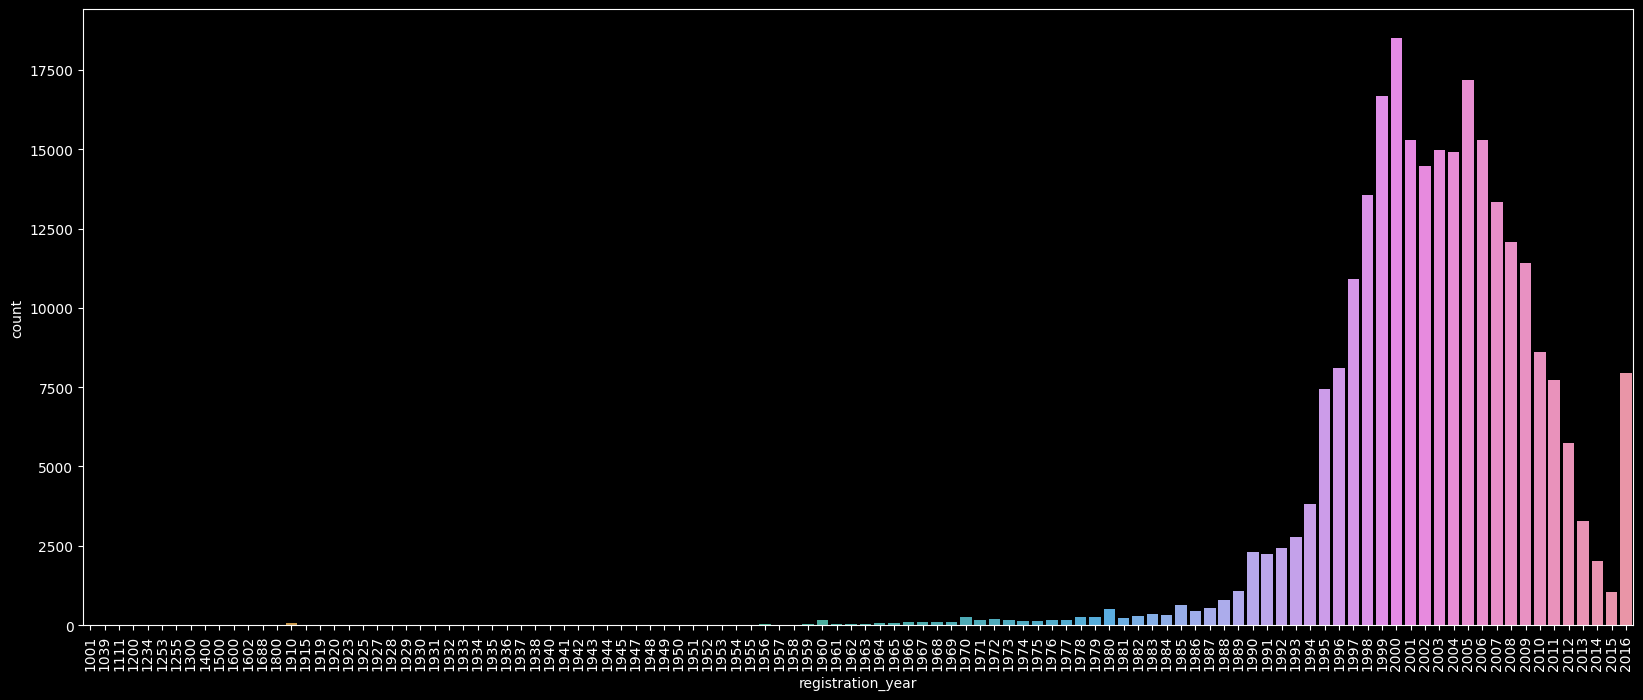

In [35]:
plt.figure(figsize=(20,8))
sns.countplot(data = df, x = 'registration_year')
plt.xticks(rotation=90);

Мы видим, что осталось еще много маленьких значений, которые похожи на выбросы, удалим данные о машинах, зарегистрированных до 1990 года.

In [36]:
df = df.query('registration_year >= 1990')

In [37]:
# Посмотрим на статистику по колонке kilometer
df['kilometer'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
kilometer,254107.0,127730.837797,37867.757247,5000.0,125000.0,150000.0,150000.0,150000.0


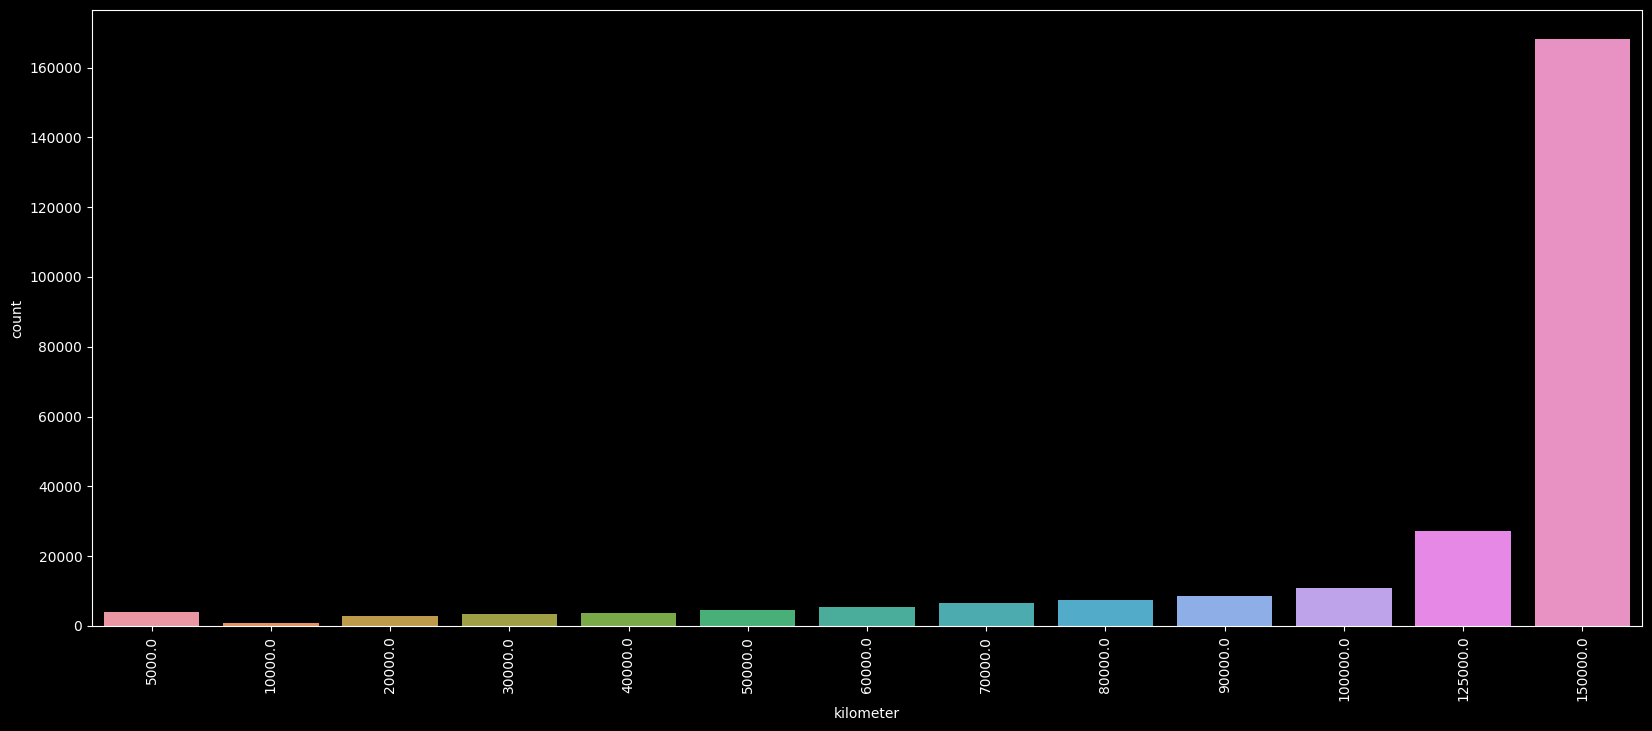

In [38]:
plt.figure(figsize=(20,8))
sns.countplot(data = df, x = 'kilometer')
plt.xticks(rotation=90);

Мы видим, что данные о пробеге округлены, но явных выбросов в них нет. Есть пиковое значение в районе 150 тыс. км.

In [39]:
# Посмотрим на статистику по колонке power
df['power'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
power,254107.0,112.912942,197.913225,0.0,72.0,105.0,143.0,20000.0


Видно, что в данных есть выбросы (слишком большие значения и слишком маленькие значения). Удалим значения меньше 50 л.с. и больше 1600 л.с.

In [40]:
df =  df.query('50 <= power <= 1600')

In [41]:
df['power'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
power,223733.0,123.78448,59.758084,50.0,82.0,115.0,150.0,1600.0


Посмотрим на значения в колонке с целевым признаком.

In [42]:
df['price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,223733.0,4884.439721,4671.795044,0.0,1300.0,3200.0,7000.0,20000.0


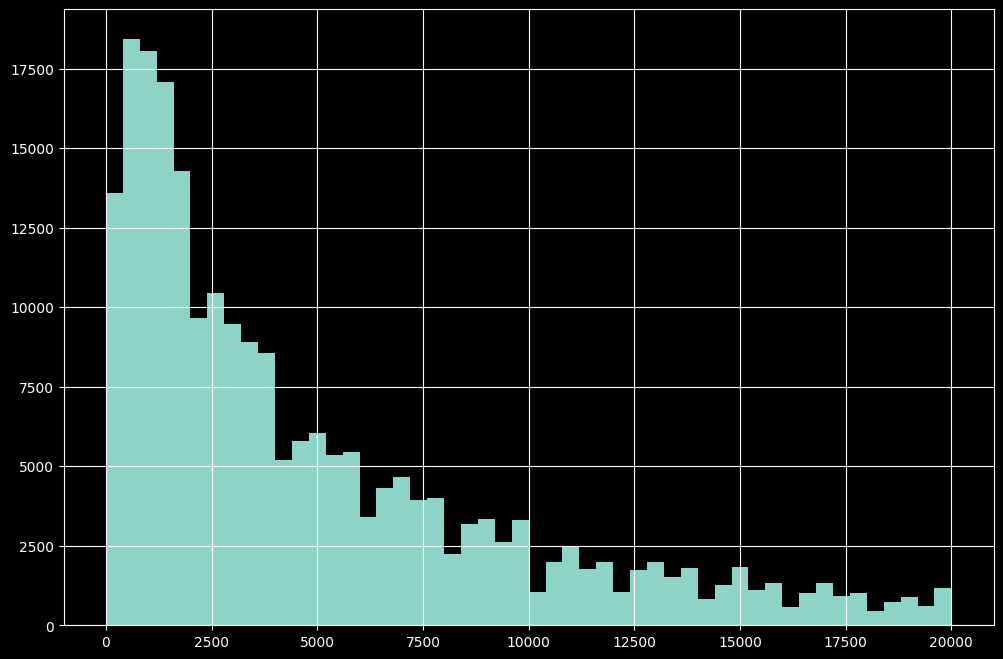

In [43]:
df['price'].hist(bins=50, figsize=(12, 8));


В данных есть слишком маленькие значения, удалим их (проведем границу по значению 500 евро).

In [44]:
df = df.query('price >= 500')

In [45]:
df = df.reset_index(drop=True)

#### Вывод по разделу
Мы посмотрели на числовые данные и удалили аномальные значения:
1. Год регистрации ограничили диапазоном 1990—2016.
2. В мощности удалили маленькие значения (менее 50 л.с.) и слишком большие (более 1600 л.с.).
3. В столбце с ценой удалили значения меньше 500 евро.

## Обучение моделей

### Случайный лес

В наших данных есть категориальные признаки, для модели случайного леса их надо закодировать. Используем OrdinalEncoder. Только сначала разобьем данные на тренировочную и тестовую выборки.

In [46]:
features = df.drop('price', axis=1)
target = df['price']
features_train, features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.25, random_state=1508)
)

In [47]:
# Проверим размер после разбиения данных
print(len(features_train) / len(df))
len(features_test) / len(df)

0.7499987915407855


0.2500012084592145

In [48]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [49]:
df.dtypes

price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                float64
model                 object
kilometer            float64
fuel_type             object
brand                 object
repaired              object
dtype: object

In [50]:
encoder = OrdinalEncoder()
cat_features = df.select_dtypes(include='object').columns
features_train_enc = features_train.copy()
features_test_enc = features_test.copy()
features_train_enc[cat_features] = encoder.fit_transform(features_train[cat_features]).astype('int')
features_test_enc[cat_features] = encoder.fit_transform(features_test[cat_features]).astype('int')

Подберем наилучшие параметры случайного леса.

In [51]:
rfm = RandomForestRegressor(random_state=1508)

rfm_params_rs = {'n_estimators': range (2, 20, 2),
              'max_depth': range (1, 20, 2),
              'min_samples_leaf': range (1, 20, 5) }

rfm_rs = (
    RandomizedSearchCV(rfm, rfm_params_rs, scoring='neg_root_mean_squared_error',
                       random_state=1508)
)

In [52]:
rfm_rs.fit(features_train_enc, target_train)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=1508),
                   param_distributions={'max_depth': range(1, 20, 2),
                                        'min_samples_leaf': range(1, 20, 5),
                                        'n_estimators': range(2, 20, 2)},
                   random_state=1508, scoring='neg_root_mean_squared_error')

In [53]:
rfm_res = pd.DataFrame(rfm_rs.cv_results_)
time_fit_rfm = rfm_res.iloc[rfm_rs.best_index_]['mean_fit_time']
time_predict_rfm = rfm_res.iloc[rfm_rs.best_index_]['mean_score_time']

In [54]:
rfm_results = pd.DataFrame(
    data = [time_fit_rfm, time_predict_rfm, abs(rfm_rs.best_score_)],
    index = ['Время обучения', 'Время предсказания', 'Лучший RMSE'])
rfm_results = rfm_results.rename(columns = {0:''})
rfm_results.style.set_caption('Модель случайного леса')


,
Время обучения,4.321312
Время предсказания,0.100067
Лучший RMSE,1651.633465


Посмотрим, какие признаки оказались наиболее значимыми для модели случайного леса.

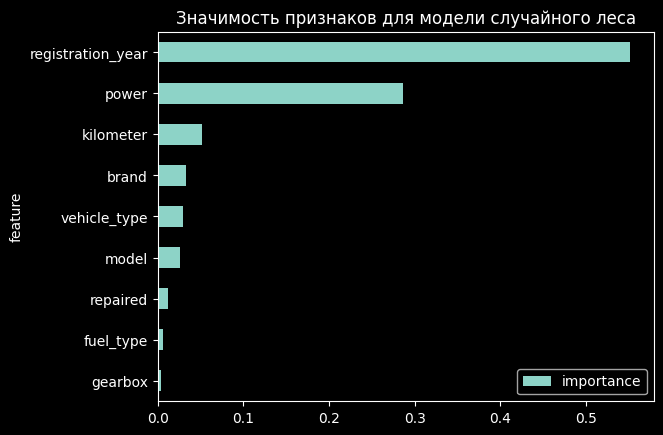

In [55]:
top_params_rfm = rfm_rs.best_params_
rf_model = RandomForestRegressor(n_estimators=top_params_rfm['n_estimators'], 
                                 max_depth=top_params_rfm['max_depth'], 
                                 min_samples_leaf=top_params_rfm['min_samples_leaf'],
                                 random_state=1508)
rf_model.fit(features_train_enc, target_train)
fi_rfm = pd.DataFrame({'feature': list(features_train_enc.columns),
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = True)

fi_rfm = fi_rfm.set_index('feature')
fi_rfm.plot(kind='barh')
plt.legend(loc='lower right')
plt.title('Значимость признаков для модели случайного леса');

### Решающее дерево

Для модели дерева будем использовать закодированные признаки.

In [56]:
tree_m = DecisionTreeRegressor(random_state=1508)

tree_params_rs = {'max_depth': range (1, 100, 2),
              'min_samples_leaf': range (1, 100, 2)}

tree_rs = (
    RandomizedSearchCV(tree_m, tree_params_rs, scoring='neg_root_mean_squared_error',
                       random_state=1508)
)

In [57]:
tree_rs.fit(features_train_enc, target_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=1508),
                   param_distributions={'max_depth': range(1, 100, 2),
                                        'min_samples_leaf': range(1, 100, 2)},
                   random_state=1508, scoring='neg_root_mean_squared_error')

In [58]:
tree_res = pd.DataFrame(tree_rs.cv_results_)
time_fit_tree = tree_res.iloc[tree_rs.best_index_]['mean_fit_time']
time_predict_tree = tree_res.iloc[tree_rs.best_index_]['mean_score_time']

In [59]:
tree_results = pd.DataFrame(
    data = [time_fit_tree, time_predict_tree, abs(tree_rs.best_score_)],
    index = ['Время обучения', 'Время предсказания', 'Лучший RMSE'])
tree_results = tree_results.rename(columns = {0:''})
tree_results.style.set_caption('Решающее дерево')


,
Время обучения,0.417133
Время предсказания,0.010375
Лучший RMSE,1791.110570


Посмотрим, какие признаки оказались наиболее значимыми для модели решающего дерева.

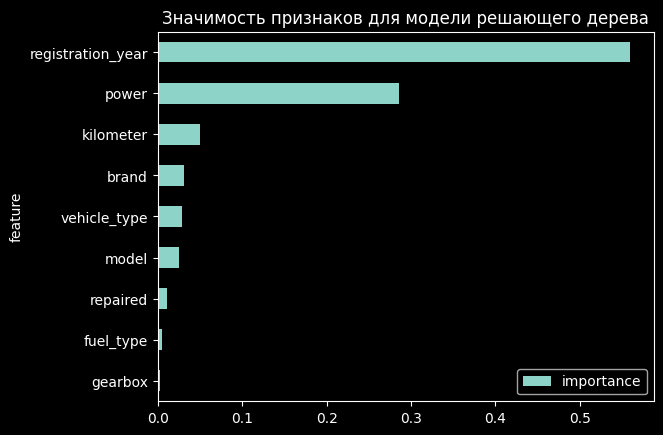

In [60]:
top_params_tree = tree_rs.best_params_
tree_model = DecisionTreeRegressor(max_depth=top_params_tree['max_depth'], 
                                 min_samples_leaf=top_params_tree['min_samples_leaf'],
                                 random_state=1508)
tree_model.fit(features_train_enc, target_train)
fi_tree = pd.DataFrame({'feature': list(features_train_enc.columns),
                   'importance': tree_model.feature_importances_}).\
                    sort_values('importance', ascending = True)

fi_tree = fi_tree.set_index('feature')
fi_tree.plot(kind='barh')
plt.legend(loc='lower right')
plt.title('Значимость признаков для модели решающего дерева');

### LightGBM

In [61]:
lgbm = LGBMRegressor(random_state=1508)

lgbm_params = {'num_leaves': range (5, 50, 10),
              'n_estimators': range (2, 50, 5),
              'max_depth': range (2, 20, 2)}

lgbm_rs = RandomizedSearchCV(lgbm, lgbm_params, 
                             scoring='neg_root_mean_squared_error',
                             random_state=1508)

Воспользуемся внутренним способом кодировки категориальных признаков модели LightGBM.

In [62]:
cat_features_lgbm = features_train.select_dtypes(include='object').columns
features_train[cat_features_lgbm] = features_train[cat_features_lgbm].astype('category')


In [63]:
lgbm_rs.fit(features_train, target_train)



RandomizedSearchCV(estimator=LGBMRegressor(random_state=1508),
                   param_distributions={'max_depth': range(2, 20, 2),
                                        'n_estimators': range(2, 50, 5),
                                        'num_leaves': range(5, 50, 10)},
                   random_state=1508, scoring='neg_root_mean_squared_error')

In [64]:
lgbm_res = pd.DataFrame(lgbm_rs.cv_results_)
time_fit_lgbm = lgbm_res.iloc[lgbm_rs.best_index_]['mean_fit_time']
time_predict_lgbm = lgbm_res.iloc[lgbm_rs.best_index_]['mean_score_time']

In [65]:
lgbm_results = pd.DataFrame(
    data = [time_fit_lgbm, time_predict_lgbm, abs(lgbm_rs.best_score_)],
    index = ['Время обучения', 'Время предсказания', 'Лучший RMSE'])
lgbm_results = lgbm_results.rename(columns = {0:''})
lgbm_results.style.set_caption('Модель LightGBM')


,
Время обучения,0.541199
Время предсказания,0.085858
Лучший RMSE,1610.218598


Посмотрим, какие признаки оказались значимыми для модели LightGBM.

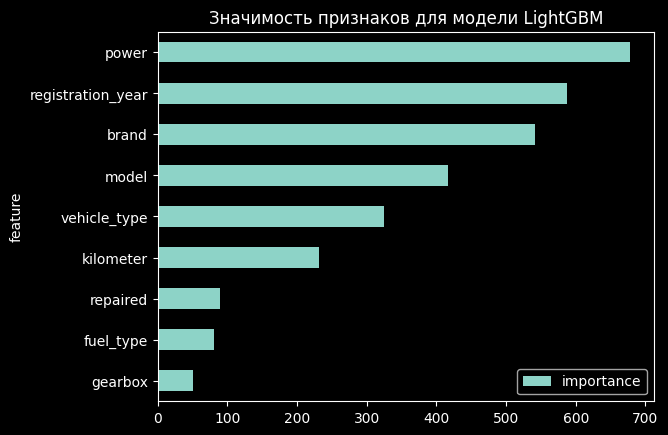

In [66]:
top_params_lgbm = lgbm_rs.best_params_
lgbm_model = LGBMRegressor(max_depth=top_params_tree['max_depth'], 
                                 min_samples_leaf=top_params_tree['min_samples_leaf'],
                                 random_state=1508)
lgbm_model.fit(features_train_enc, target_train)
fi_lgbm = pd.DataFrame({'feature': list(features_train_enc.columns),
                   'importance': lgbm_model.feature_importances_}).\
                    sort_values('importance', ascending = True)

fi_lgbm = fi_lgbm.set_index('feature')
fi_lgbm.plot(kind='barh')
plt.legend(loc='lower right')
plt.title('Значимость признаков для модели LightGBM');

### Дамми-модель

Сделаем дамми-модель, которая будет заполнять целевой признак медианным значением.

In [67]:
dummy_m = DummyRegressor(strategy='median')

dummy_params = {}
dummy_rs = RandomizedSearchCV(dummy_m, dummy_params, 
                             scoring='neg_root_mean_squared_error',
                             random_state=1508)

In [68]:
dummy_rs.fit(features_train_enc, target_train)

RandomizedSearchCV(estimator=DummyRegressor(strategy='median'),
                   param_distributions={}, random_state=1508,
                   scoring='neg_root_mean_squared_error')

In [69]:
dummy_res = pd.DataFrame(dummy_rs.cv_results_)
time_fit_dummy = dummy_res.iloc[dummy_rs.best_index_]['mean_fit_time']
time_predict_dummy = dummy_res.iloc[dummy_rs.best_index_]['mean_score_time']

In [70]:
dummy_results = pd.DataFrame(
    data = [time_fit_dummy, time_predict_dummy, abs(dummy_rs.best_score_)],
    index = ['Время обучения', 'Время предсказания', 'Лучший RMSE'])
dummy_results = dummy_results.rename(columns = {0:''})
dummy_results.style.set_caption('Дамми-модель')


,
Время обучения,0.013172
Время предсказания,0.001359
Лучший RMSE,4947.303529


## Анализ моделей

Сравним показатели (RMSE, скорость обучения и предсказания) обученных моделей.

In [71]:
# Объединим наши результаты по трем моделям
final = pd.concat([rfm_results, tree_results, lgbm_results, dummy_results], axis=1)
final.columns = ['Случайный лес', 'Решающее дерево', 'LightGBM', 'Дамми-модель']
final

,Случайный лес,Решающее дерево,LightGBM,Дамми-модель
Время обучения,4.321312,0.417133,0.541199,0.013172
Время предсказания,0.100067,0.010375,0.085858,0.001359
Лучший RMSE,1651.633465,1791.110570,1610.218598,4947.303529


По времени обучения и предсказания лучший результат — у модели решающего дерева. Но она проигрывает по RMSE.
Для проверки на тестовой выборке мы остановимся на модели LightGBM, т.к. у нее оптимальное соотношение качества и времени предсказания/обучения.

In [72]:
features_test[cat_features_lgbm] = features_test[cat_features_lgbm].astype('category')

In [73]:
%%time
lgbm_test_preds = lgbm_rs.best_estimator_.predict(features_test)

CPU times: user 269 ms, sys: 1.94 ms, total: 271 ms
Wall time: 229 ms


In [74]:
test_rmse = mean_squared_error(target_test, lgbm_test_preds)**0.5
test_rmse

1570.296301130809

## Общий вывод

В этом проекте мы обучили модель для быстрого предсказания цены на подержанные автомобили. Важно было не только добиться определенного качества (значения метрики RMSE не ниже 2500), но и выбрать наиболее оптимальную модель с точки зрения скорости обучения и предсказания, поскольку она будет использоваться в приложении (пользователи вводят данные об автомобиле и получают на выходе цену).

1. Была проведена предобработка данных (удалены не значимые для модели признаки, заполнены пропуски, обработаны аномальные значения).
2. Были обучены три модели — решающее дерево, случайный лес и LightGBM (модель, в основе которой лежит алгоритм градиентного бустинга). Также проверена адекватность моделей с помощью дамми-модели.
3. По результатам исследования была выбрана модель LightGBM — она показала оптимальные результаты с точки зрения соотношения показателей качество/скорость.
4. Указанная модель была проверена на тестовой выборке и показала хорошее значение метрики RMSE.